<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.891 · Aprendizaje automático · PEC2</p>
<p style="margin: 0; text-align:right;">2024-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


#  PEC 2 - Descubriendo patrones ocultos: proyecciones, agrupaciones y significado latente en datos no etiquetados

En esta práctica trabajaremos con un [dataset real de sesiones de escucha de música procedente de 1000 usuarios de LastFM](http://ocelma.net/MusicRecommendationDataset/lastfm-1K.html). A partir de este escenario, aprenderás a explorar y transformar el dato, a proyectarlo en distintos espacios y a descubrir estructuras ocultas sin necesidad de etiquetas.

Aplicaremos distintas técnicas de aprendizaje no supervisado para detectar agrupaciones y afinidades musicales, entendiendo mejor el comportamiento de los oyentes y las relaciones entre canciones o artistas.

Comenzaremos **explorando y preparando el dato** para las distintas técnicas que aplicaremos. Dada la gran dimensionalidad del dato necesitamos representarlo de manera densa a través de distintas técnicas de proyección no supervisadas, comenzaremos con una técnica basada en **coocurrencia** (de canciones o artistas en sesiones de un usuario). Dadas sus limitaciones probaremos dos métodos de proyección alternativos: uno **probabilístico** (LDA que además es un algoritmo de clustering) y otro que **factoriza matrices** (ALS que además nos permite hacer recomendaciones). *Opcionalmente* se presenta la oportunidad de explorar las **proyecciones algebraicas** a través de una versión simplificada de un modelo item2vec.

**Importante:** cada uno de los ejercicios puede suponer varios minutos de ejecución (muchos métodos utilizados en la práctica tienen un parámetro llamado `n_jobs` que con valor `-1` paraleliza tareas y puede reducir los tiempos de ejecución), por lo que la entrega debe hacerse en formato notebook y en formato html, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a html desde el menú File $\to$ Download as $\to$ HTML.

**Importante:** existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de cada PEC. Para cambiar el tipo de celda a este tipo, elegid en el menú: Cell $\to$ Cell Type $\to$ Markdown.

**Importante:** la solución planteada no debe utilizar métodos, funciones o parámetros declarados "deprecated" en futuras versiones.

**Importante:** es conveniente que utilicéis una semilla con un valor fijo (en este Notebook se os propone la variable _seed_ inicializada a 100) en todos aquellos métodos o funciones que contengan alguna componente aleatoria para aseguraros de que obtendréis siempre el mismo resultado en las distintas ejecuciones de vuestro código.

**Importante:** no olvidéis poner vuestro nombre y apellidos en la siguiente celda.

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos: Pablo Perez Verdugo</strong>
</div>

Para la realización de la práctica necesitaremos installar e importar los siguientes módulos:

In [1]:
from collections import defaultdict
from itertools import permutations
import pickle
import random
import warnings

from adjustText import adjust_text
from implicit.als import AlternatingLeastSquares
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.decomposition import LatentDirichletAllocation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import tqdm
import umap


warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.deprecation")

# plt.rcParams['font.family'] = 'Arial Unicode MS' # No tengo esta fuente y me da problemas al instalarla

%matplotlib inline

# 1. Preparación del dato: LastFM 1K (1 punto)

Trabajaremos con una versión del dataset LastFM 1K, un conjunto real de datos recopilado desde la plataforma musical Last.fm. Contiene el historial de escucha de aproximadamente 1.000 usuarios, donde se registran las canciones que cada usuario ha escuchado, con información sobre:

 - El usuario (en formato id)

 - La fecha y hora de reproducción
 
 - El artista (en formato id y nombre)

 - La canción (en formato id y título)

Para ello puedes cargar el dato de la siguiente manera: 

In [2]:
df = pd.read_csv("music.tsv", sep="\t", header=0)
len(df)

4611767

## 1.1 Eliminar duplicados

Un mismo usuario puede haber escuchado una misma canción varias veces a lo largo del tiempo. Como en este caso no nos interesa cuándo ocurrió cada escucha, eliminaremos los registros duplicados.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Conserva solo una fila por combinación de `usuario`, `artista` y `canción`, ignorando el `timestamp`.
</div>


In [3]:
df = df.drop_duplicates()
len(df) # 4611767 Vemos que no habia duplicados, esto se debe a que el dataset original ya tenia las timestamps eliminadas

4611767

## 1.2 Filtrado de canciones con poca repercusión

Para reducir el tamaño del dataset y centrarnos en las canciones con mayor relevancia, eliminaremos aquellas que hayan tenido muy poca repercusión.

Este filtrado nos ayudará a ahorrar **tiempo de cómputo** y **memoria** en los pasos posteriores.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Conserva solo las canciones que hayan sido escuchadas por más de 20 usuarios distintos.
</div>

In [4]:
# Agrupamos por track y por artist ya que dos canciones de artistas distintos pueden tener el mismo nombre
df["num_track_listeners"] = df.groupby(["track", "artist"])["user_id"].transform("nunique") 
df = df[df["num_track_listeners"] > 20]
len(df)

1500829

## 1.3 Identificación de artistas y canciones únicos

Vamos a generar tres series de pandas que nos serán útiles más adelante: una con todos los **usuarios únicos**, otra con todos los **artistas únicos** y una última con todas las **canciones únicas** del dataset.

Crea tres objetos `unique_users`, `unique_artists` y `unique_songs`, que contengan los valores únicos de `user_id`, `artist` y `artist` + `track`, respectivamente, y que tengan un **índice correlativo de 0 a N**. Para ello, puedes utilizar `.reset_index(drop=True)` en tu solución.

A partir de las series `unique_artists` y `unique_songs`, vamos a crear cuatro diccionarios que nos permitirán **mapear entre nombres (strings) e índices (enteros correlativos comenzando desde el 0)**, y viceversa.

Crea los siguientes diccionarios:

- `user_to_idx`: mapea el id de usuario (str) a su índice.
- `idx_to_user`: mapea el índice al id de usuario (str).
  
- `artist_to_idx`: mapea el nombre del artista a su índice.
- `idx_to_artist`: mapea el índice al nombre del artista.

- `song_to_idx`: mapea el nombre de la canción a su índice.
- `idx_to_song`: mapea el índice al nombre de la canción.

Estos diccionarios serán muy útiles para representar el dataset numéricamente en etapas posteriores.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Crea los objetos unique_users, user_to_idx, idx_to_user, unique_artists, artist_to_idx, idx_to_artist, unique_songs, song_to_idx y idx_to_song.
</div>

In [5]:
unique_users = df['user_id'].drop_duplicates().reset_index(drop=True)
unique_artists = df['artist'].drop_duplicates().reset_index(drop=True)

# Para unique_songs debemos usar artista + track
unique_songs = df[['artist', 'track']].drop_duplicates()
unique_songs['artist_track'] = unique_songs['artist'] + " - " + unique_songs['track']
unique_songs = unique_songs['artist_track'].reset_index(drop=True)

# Diccionarios
user_to_idx = {user: idx for idx, user in unique_users.items()}
idx_to_user = {idx: user for idx, user in unique_users.items()}
artist_to_idx = {artist: idx for idx, artist in unique_artists.items()}
idx_to_artist = {idx: artist for idx, artist in unique_artists.items()}
song_to_idx = {song: idx for idx, song in unique_songs.items()}
idx_to_song = {idx: song for idx, song in unique_songs.items()}

Comprobaciones sobre los datos:

In [6]:
assert len(unique_users) == 991 and unique_users.index.min() == 0 and unique_users.index.max() == 990, '# of users does not match!'
assert len(unique_artists) == 2821 and unique_artists.index.min() == 0 and unique_artists.index.max() == 2820, '# of artists does not match!'
assert len(unique_songs) == 32790 and unique_songs.index.min() == 0 and unique_songs.index.max() == 32789, '# of songs does not match!'

## 2. Construcción de las matrices de coocurrencia usuario-artista y usuario-canción (3 puntos)

Vamos a representar las interacciones entre usuarios y contenido musical en formato matricial, lo que nos permitirá trabajar con los datos de forma vectorial en los siguientes bloques de la práctica.

Crea dos matrices binarias:

- `user_artist_matrix`: representa si un usuario ha escuchado al menos una vez a al artista.
- `user_song_matrix`: representa si un usuario ha escuchado al menos una vez la canción.

De tal manera que en la fila i tendremos todas las artistas/canciones que ha escuchado el usuario i, y tendrá tantas columnas como artistas y canciones haya.

Ambas matrices tendrán valores:

- **1** si el usuario ha escuchado al artista o la canción.
- **0** si no lo ha hecho.

Por tanto, la celda `user_artist_matrix[i,j]` representará si el *i-ésimo* usuario ha escuchado al *j-ésimo* artista.

Estas matrices nos permitirán codificar los usuarios, artistas y canciones como vectores y aplicar técnicas de reducción de dimensionalidad, agrupación o recomendación más adelante.

## 2.1 Representación dispersa

Dado que la mayoría de los usuarios **no han escuchado la mayoría de los artistas ni canciones**, estas matrices contienen muchos ceros. A este tipo de matrices se les llama **matrices dispersas (sparse matrices)**, ya que la mayoría de sus elementos son nulos.

Para trabajar con ellas de forma eficiente en memoria y en cálculo, usaremos el formato **CSR (Compressed Sparse Row)**. Este formato almacena solo los valores distintos de cero junto con sus posiciones, lo que permite ahorrar memoria y acelerar algunas operaciones.

Vamos a construir las matrices en [formato **`csr_matrix`** de la librería `scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Crea las matrices de coocurrencia.
</div>

In [7]:
# Añadimos los indices a nuestro df
df["user_idx"] = df["user_id"].map(user_to_idx)
df["artist_idx"] = df["artist"].map(artist_to_idx)
df["song_idx"] = (df["artist"] + " - " + df["track"]).map(song_to_idx)

# Matriz Usuario - Artista
user_artist_matrix = csr_matrix(
    (np.ones(len(df)), (df["user_idx"], df["artist_idx"])),
    shape=(len(unique_users), len(unique_artists))
)

# Matriz Usuario - Canción
user_song_matrix = csr_matrix(
    (np.ones(len(df)), (df["user_idx"], df["song_idx"])),
    shape=(len(unique_users), len(unique_songs))
)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Para conocer el grado de dispersión que tiene la matriz podemos calcular la proporción de 1s con respecto al total de elementos de la matriz: user_song_matrix.
</div>

In [8]:
# Número total de 1s
num_total_ones = user_song_matrix.size

# Número total de elementos
num_total_elements = user_song_matrix.shape[0] * user_song_matrix.shape[1]

# Calculamos la proporción
proporcion = num_total_ones / num_total_elements

print(f"Número de 1s: {num_total_ones}")
print(f"Número total de elementos: {num_total_elements}")
print(f"Proporción de 1s: {proporcion:.5f}")

Número de 1s: 1500829
Número total de elementos: 32494890
Proporción de 1s: 0.04619


## 2.2 Visualización del espacio de usuarios

Ahora que cada usuario está representado como un vector en las matrices `user_artist_matrix` o `user_song_matrix`, podemos empezar a **explorar visualmente la estructura de gustos musicales**.

Cada fila de estas matrices codifica a un usuario en función de los artistas o canciones que ha escuchado. El objetivo ahora es **proyectar ese espacio a 2 dimensiones** para visualizarlo y tratar de detectar **grupos de usuarios con patrones similares de escucha**.

Sin embargo, en el caso de la matriz de artistas, cada usuario está representado por un vector de casi **3.000 dimensiones**, lo que hace imposible visualizar directamente el espacio.

Para resolver esto, vamos a aplicar una técnica de **reducción de dimensionalidad** que nos permita mantener la estructura del espacio original y proyectarlo en 2D. Algunas de las técnicas más comunes para este tipo de tarea son: *PCA (Análisis de Componentes Principales)*, *t-SNE (t-distributed Stochastic Neighbor Embedding)* o *UMAP (Uniform Manifold Approximation and Projection)*. Ten en cuenta que con el tiempo tendremos nuevos usuarios y querremos añadirlos a la proyección del espacio junto a los otros usuarios que ya tenemos (sin tener que recalcular todo).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> investiga y justifica cuál de estas técnicas consideras más adecuada para este caso indicando los criterios que has tenido en cuenta.
</div>

Si miramos la página https://www.datacamp.com/tutorial/introduction-t-sne vemos lo siguiente:

"**Limitations and Challenges of t-SNE**

While t-SNE is a powerful visualization tool for high-dimensional data, it comes with some limitations:

1. Computational cost: t-SNE is computationally expensive, especially for large datasets. Its pairwise similarity calculations scale poorly with the size of the dataset, making it less suitable for datasets with millions of points.
2. Sensitivity to hyperparameters: The performance of t-SNE is highly dependent on hyperparameters like perplexity and learning rate. Finding the optimal values often requires trial and error, which can be time-consuming.
3. Lack of interpretability: The resulting embeddings in t-SNE are often non-deterministic (due to random initialization and gradient descent) and lack a direct interpretable relationship with the original high-dimensional data.
4. Not suitable for out-of-sample data: t-SNE cannot generalize to new, unseen data without re-computing the embeddings from scratch, which is inefficient for dynamic datasets."

Uno de los requisitos del enunciado es que con el tiempo tendremos nuevos usuarios y querremos añadirlos a la proyección del espacio junto a los otros usuarios que ya tenemos (sin tener que recalcular todo) -> **debido a esto debemos descartar el t-SNE ya que no se puede aplicar a nuevos datos sin recalcular todo** (Punto 4 de datacamp.com)

Para decidirnos entre PCA y UMAP consultaremos la siguiente página: https://carnotresearch.medium.com/understanding-dimensionality-reduction-pca-vs-t-sne-vs-umap-vs-fit-sne-vs-largevis-vs-laplacian-13d0be9ef7f4#:~:text=%2A%20t,efficiency%20makes%20it%20suitable%20for, donde vemos que PCA se usa para variables con relaciones lineales y se centra en preservar la estructura global de los datos. Sin embargo UMAP es una tecnica no lineal que se centra en preservar ambas estructuras, la local y global de los datos.

Además me ha llamado la atención que en las librerias cargadas en este notebook no aparecen ni PCA ni TSNE, esto es un gran indicador de que el favorito es UMAP ya que el notebook ha sido preparado por el profesor.

Debido a toda la información consultada en ambas páginas considero que la técnica más adecuada para nuestro caso es UMAP.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Visualiza el resultado de la reducción en un gráfico 2D con matplotlib y comenta si se observan agrupamientos o patrones interesantes en ambas matrices. En caso de encontrar estructuras elige y aplica la técnica de clustering adecuada para localizarlas. En función de las estructuras presentes puedes seleccionar k-means, LDA, jerárquico, mean-shift, optics, DBSCAN, o espectral. <strong>En todos los gráficos utiliza el parámetro figsize=(15, 15) para garantizar un tamaño que permita interpretarlo correctamente</strong>.
</div>

c:\Users\Pablo\Desktop\Master UOC\Aprendizaje Automático\PEC2\pec2_venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


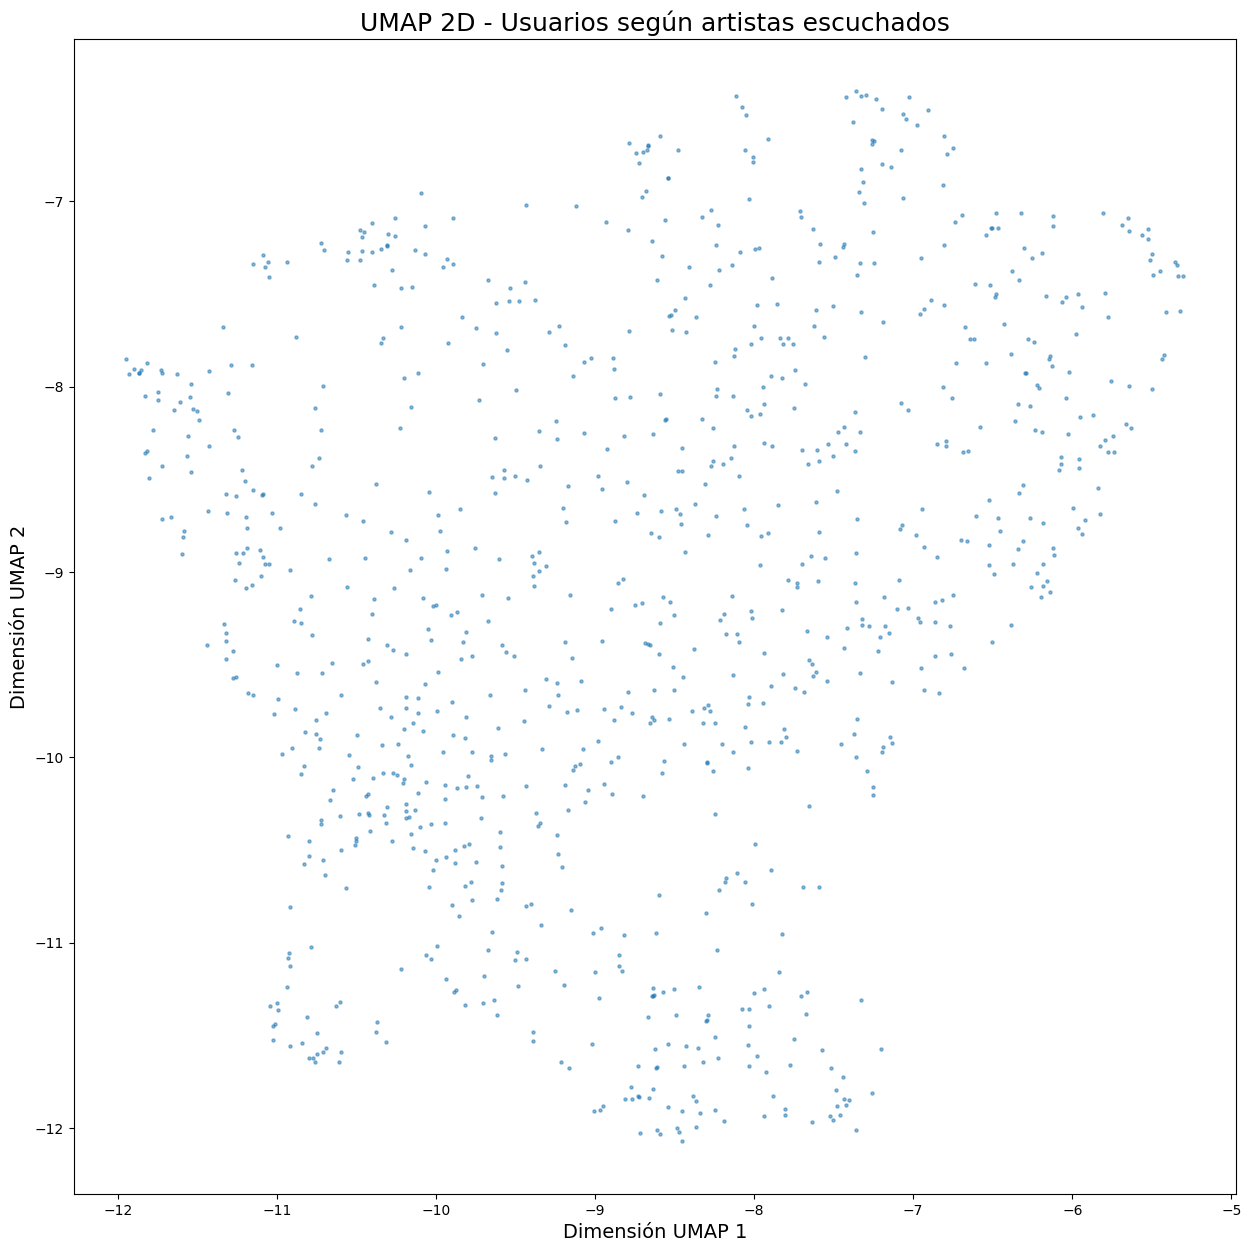

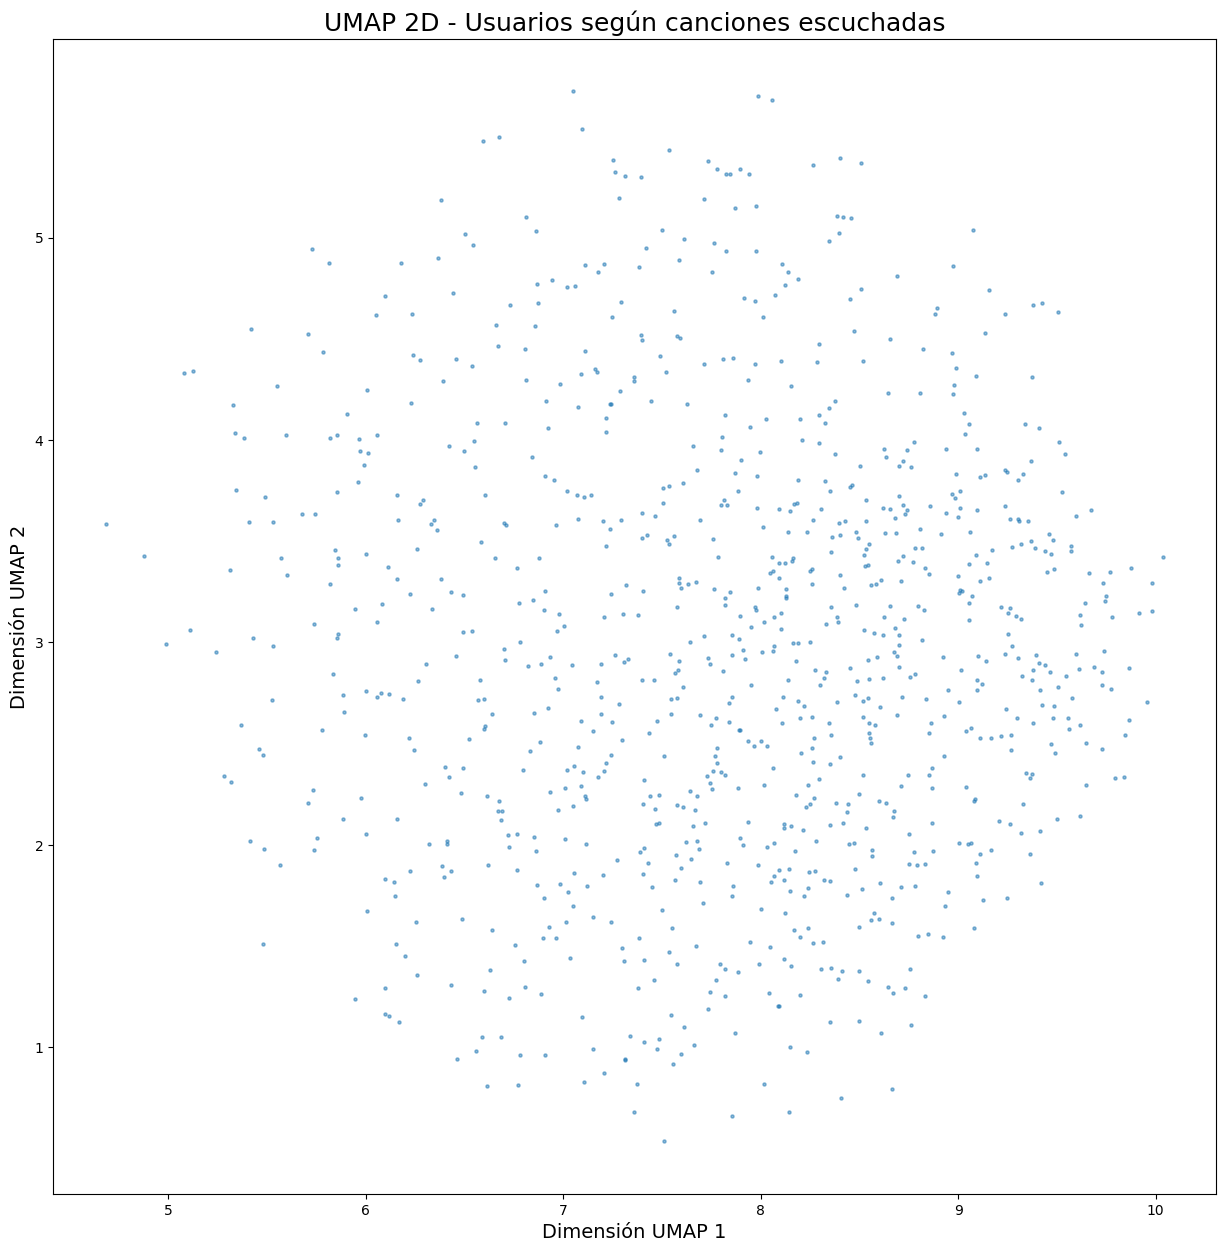

In [9]:
# Reducimos dimensionalidad con UMAP
reducer = umap.UMAP(random_state=100)
user_artist_reduced = reducer.fit_transform(user_artist_matrix)
user_song_reduced = reducer.fit_transform(user_song_matrix)

# Usuario - Artista
plt.figure(figsize=(15, 15))
plt.scatter(user_artist_reduced[:, 0], user_artist_reduced[:, 1], s=5, alpha=0.5)
plt.title('UMAP 2D - Usuarios según artistas escuchados', fontsize=18)
plt.xlabel('Dimensión UMAP 1', fontsize=14)
plt.ylabel('Dimensión UMAP 2', fontsize=14)
plt.show()

# Usuario - Canción
plt.figure(figsize=(15, 15))
plt.scatter(user_song_reduced[:, 0], user_song_reduced[:, 1], s=5, alpha=0.5)
plt.title('UMAP 2D - Usuarios según canciones escuchadas', fontsize=18)
plt.xlabel('Dimensión UMAP 1', fontsize=14)
plt.ylabel('Dimensión UMAP 2', fontsize=14)
plt.show()


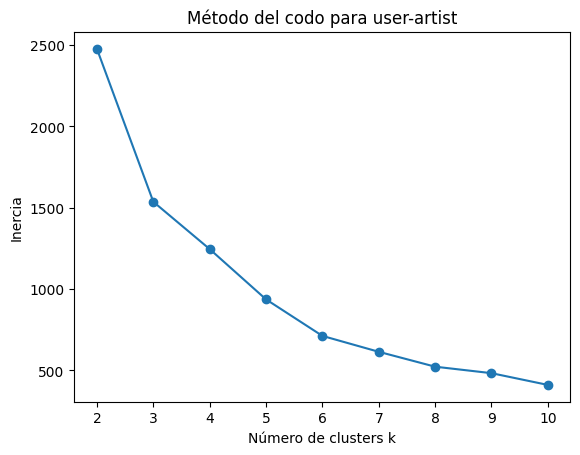

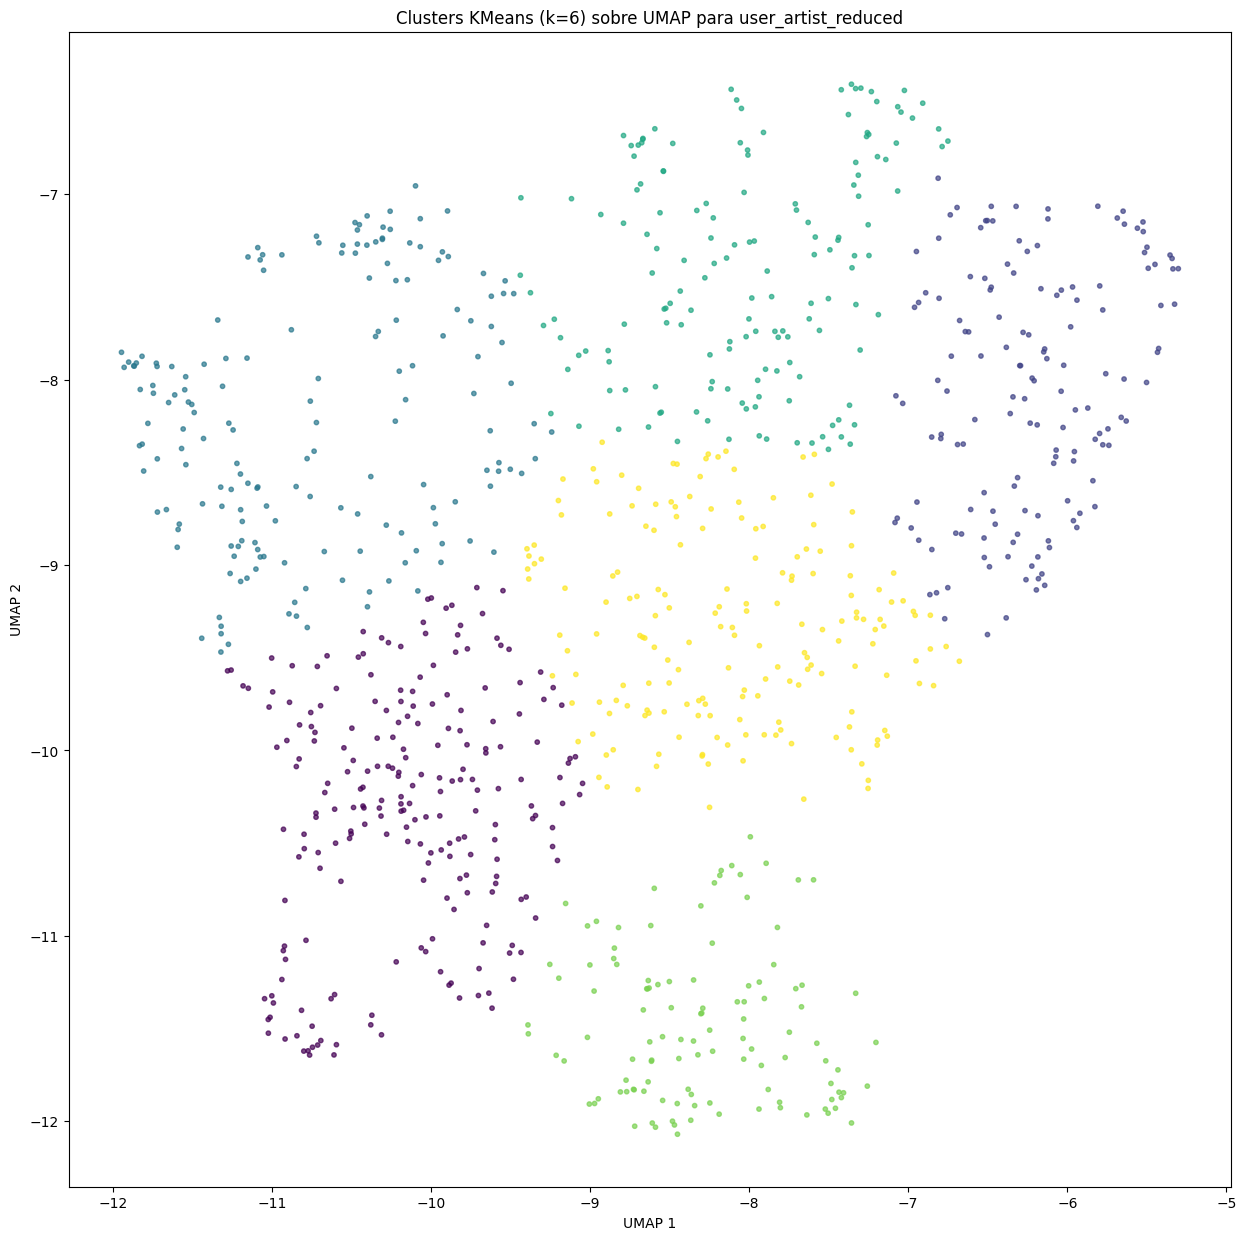

In [10]:
from sklearn.cluster import KMeans

# Método del codo para determinar k
inertias = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=100).fit(user_artist_reduced)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(range(2, 11), inertias, marker='o')
plt.title('Método del codo para user-artist')
plt.xlabel('Número de clusters k')
plt.ylabel('Inercia')
plt.show()

# Elegimos k = 6
k = 6
kmeans_artist = KMeans(n_clusters=k, random_state=0).fit(user_artist_reduced)
labels_artist = kmeans_artist.labels_

# UMAP + KMeans user-artist
plt.figure(figsize=(15, 15))
plt.scatter(
    user_artist_reduced[:, 0],
    user_artist_reduced[:, 1],
    c=labels_artist,
    s=10,
    alpha=0.7
)
plt.title(f'Clusters KMeans (k={k}) sobre UMAP para user_artist_reduced')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Podríamos aplicar lo mismo para user_song_reduced -> No lo haremos ya que sino el notebook será muy extenso


## 2.3 Visualización de usuarios

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Realiza la misma visualización pero con las matrices transpuestas, es decir, vamos a mantener las dimensiones de artistas y canciones, y vamos a reducir la de usuarios. Su interpretación sería representar los artistas o canciones en función a como los usuarios los consumen.
</div>

c:\Users\Pablo\Desktop\Master UOC\Aprendizaje Automático\PEC2\pec2_venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


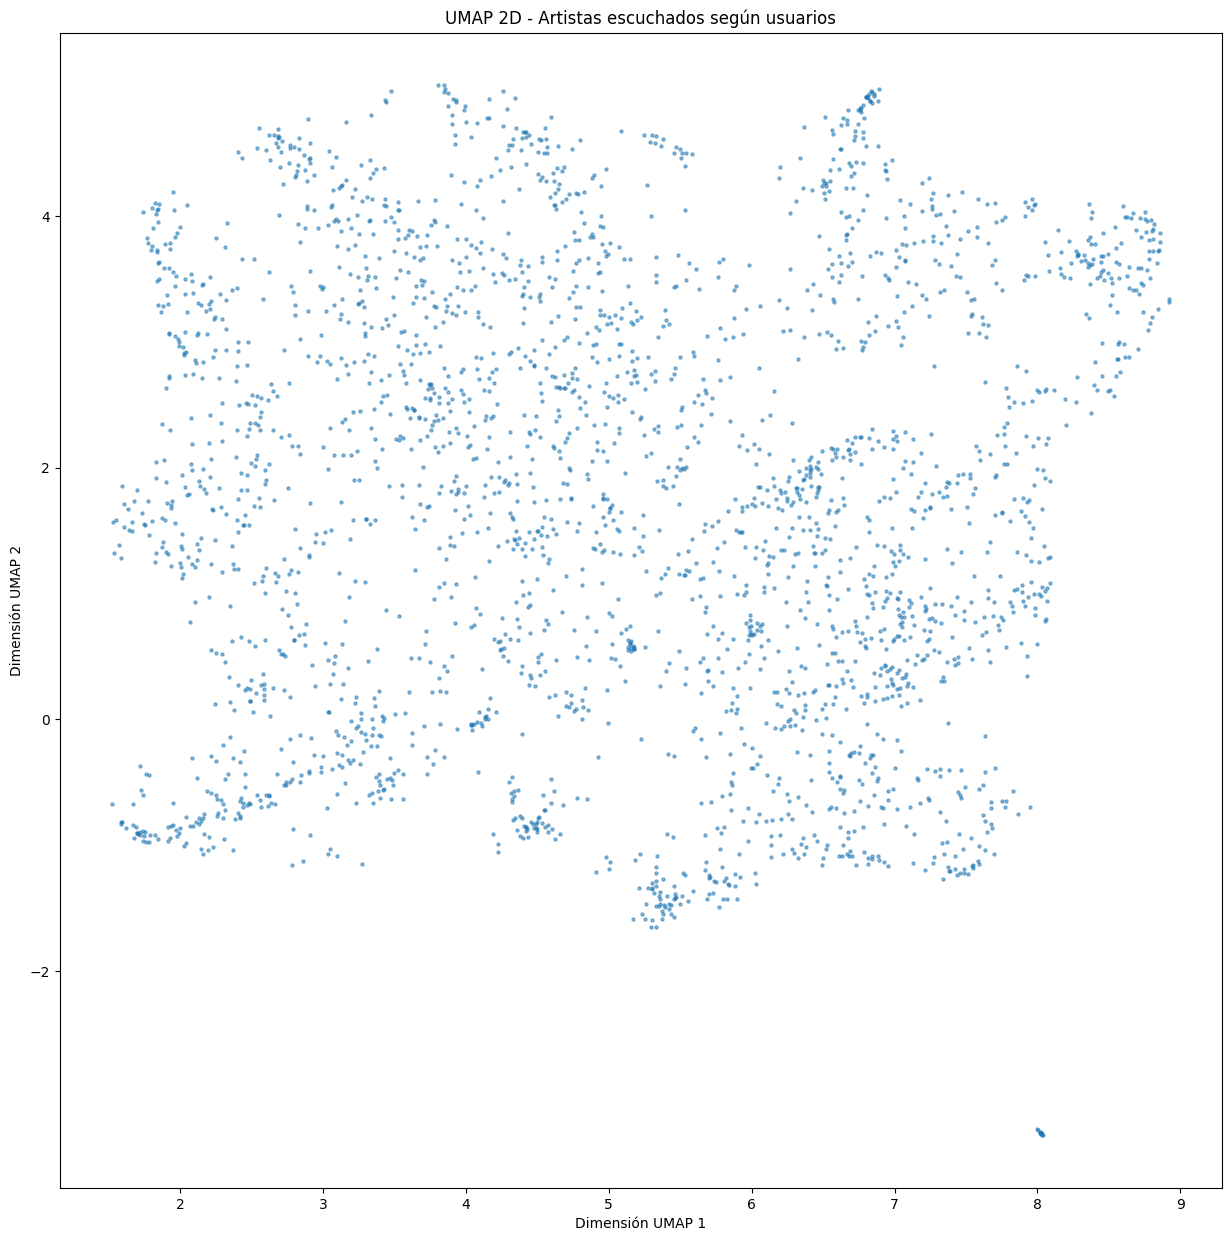

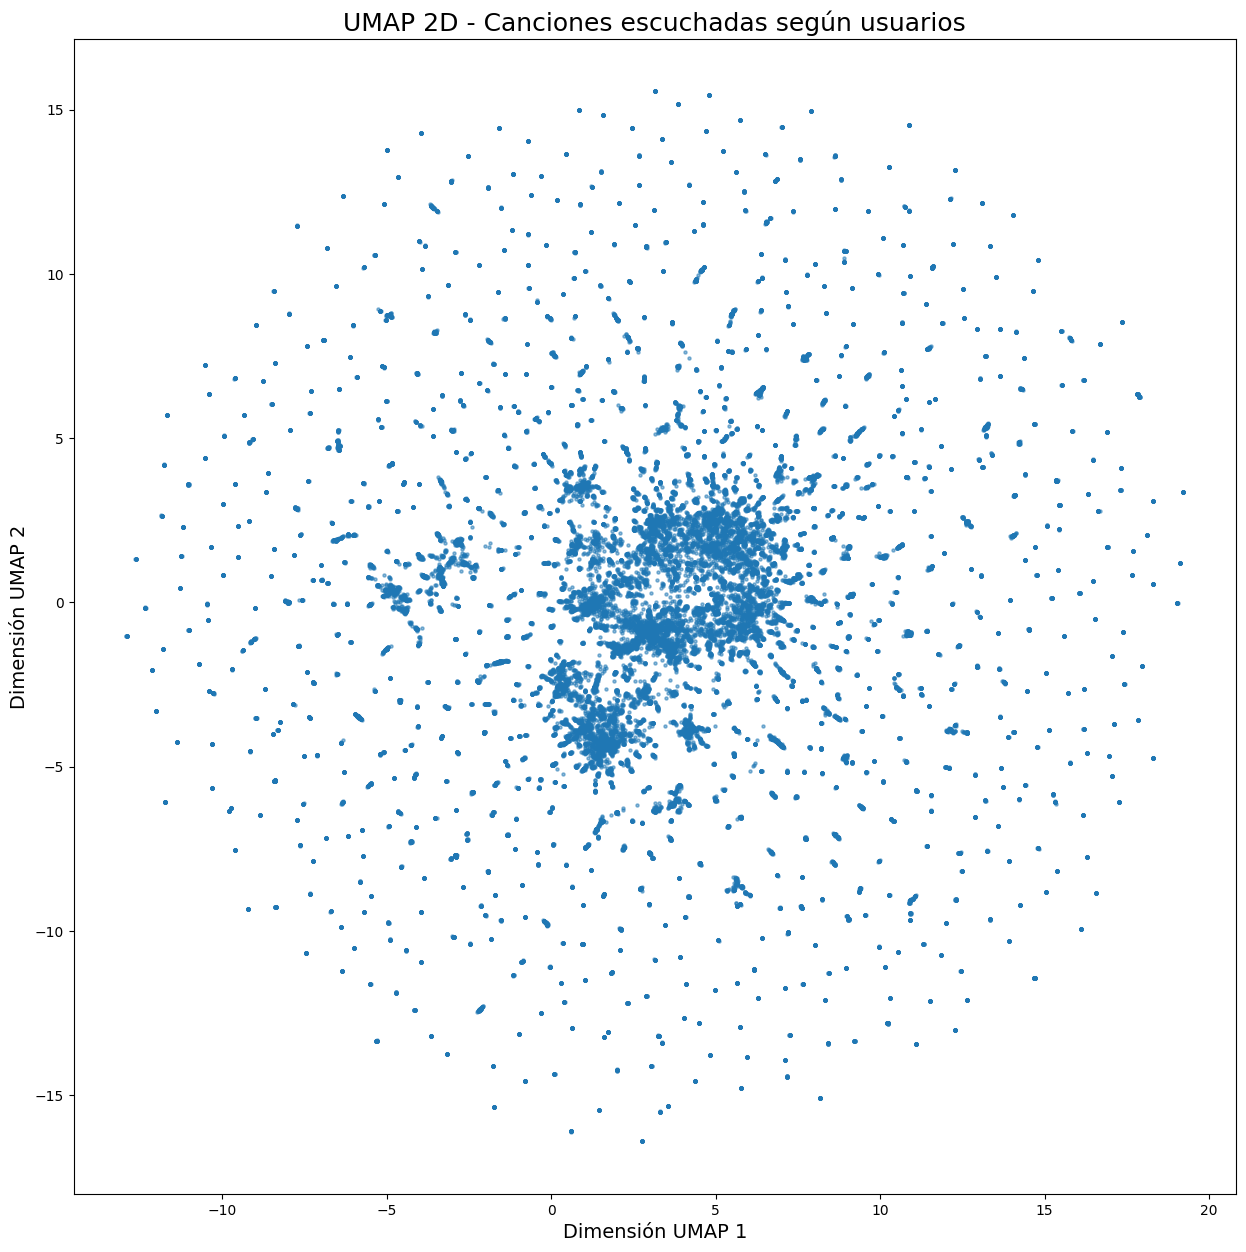

In [11]:
# Transponemos las matrices
artist_user_matrix = user_artist_matrix.transpose()
song_user_matrix = user_song_matrix.transpose()

# Reducimos dimensionalidad con UMAP
reducer = umap.UMAP(random_state=100)
artist_user_reduced = reducer.fit_transform(artist_user_matrix)
song_user_reduced = reducer.fit_transform(song_user_matrix)

# Artista - Usuario
plt.figure(figsize=(15, 15))
plt.scatter(artist_user_reduced[:, 0], artist_user_reduced[:, 1], s=5, alpha=0.5)
plt.title('UMAP 2D - Artistas escuchados según usuarios')
plt.xlabel('Dimensión UMAP 1')
plt.ylabel('Dimensión UMAP 2')
plt.show()

# Canción - Usuario
plt.figure(figsize=(15, 15))
plt.scatter(song_user_reduced[:, 0], song_user_reduced[:, 1], s=5, alpha=0.5)
plt.title('UMAP 2D - Canciones escuchadas según usuarios', fontsize=18)
plt.xlabel('Dimensión UMAP 1', fontsize=14)
plt.ylabel('Dimensión UMAP 2', fontsize=14)
plt.show()


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué observas en las nuevas representaciones de artistas y canciones?
</div>

El gráfico de canciones escuchadas según usuarios muestra unos clusteres muy densos en el centro, esto se debe a que hay canciones muy famosas que muchos usuarios escuchan, sin embargo en la periferia encontramos canciones menos populares que solo unos pocos usuarios escuchan.

En el gráfico de artistas escuchados según usuarios vemos clusters mucho más definidos pero más esparcidos esto se debe a que no hay ningún artista universal que todo el mundo escuche, los oyentes estan mejor repartidos que en el caso de las canciones.


## 3. Proyección del gusto musical con LDA (3 puntos)

En esta sección vamos a explorar una técnica diferente para reducir la dimensionalidad del gusto musical: **LDA (Latent Dirichlet Allocation)**.

A diferencia de técnicas como matriz de coocurrencia + PCA, t-SNE o UMAP, que buscan por un lado representar al usuario y reducir esa representación a menos dimensiones, **LDA tiene un enfoque más interpretativo**: trata de **descubrir temas latentes** que explican cómo se combinan los elementos observados.

## 3.1 Proyección y clustering con LDA

**LDA** es un modelo probabilístico originalmente diseñado para el **análisis de temas en textos** (topic modeling). Supone que cada documento (en nuestro caso, usuario) está formado por una **combinación de temas ocultos** (por ejemplo: 40% Pop, 20% Rock, 5% Rap...). Y que cada tema está formado por una **combinación de palabras (o artistas, en nuestro caso)**.

Cada **usuario** será tratado como un "documento". Cada **artista** será como una "palabra". El modelo intentará descubrir **temas musicales** (grupos de artistas que suelen aparecer juntos en los gustos de los usuarios).

El resultado es una representación de cada usuario como un vector de **probabilidades sobre temas latentes**, que podemos visualizar, comparar o usar como entrada a otros modelos.

Para entender LDA con una explicación visual muy clara, recomendamos [este video](https://youtu.be/1_jq_gWFUuQ).

Puedes utilizar la implementación de [LDA en scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html). El número de temas latentes es un parámetro del modelo (como la *k* de *k-means*).

Con LDA puedes obtener tanto la proyección de usuarios al espacio de temas latentes, como los artistas o canciones al espacio de temas latentes. Para asegurarte de si el resultado se corresponde con los usuarios o los artistas o canciones puedes comprobar la dimensión de la matriz obtenida.

Por ejemplo, si el resultado es una matriz `n_topics` X (`n_artists` o `n_songs`) en función de la matriz empleada. Estás obteniendo la proyección de artistas o canciones al espacio de temas latentes. Dado que LDA estima probabilísticamente cada palabra (artista o canción) a un tema latente. En este caso los usuarios equivalen a los documentos que relacionan las palabras entre sí.

Por otro lado, también puedes obtener (con otra llamada) la matriz `n_users` X `n_topics`, que representa la proyección de los usuarios al espacio de temas latentes.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Aplica LDA sobre la matriz `user_artist_matrix` para descubrir temas musicales y muestra, para cada cluster (o tema) el top 15 de artistas. Para seleccionar el valor adecuado del parámetro "temas latentes", analiza los artistas que aparecen en cada cluster y trata de que tengan un nexo común (sean homogéneos).
</div>

In [12]:
# Este parametro es variable como la k del k-means
n_topics = 8

# Creamos el modelo LDA
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=10,
    random_state=100
)
lda.fit(user_artist_matrix)

# Imprimimos top 15 artistas de cada tema
for topic_idx, topic in enumerate(lda.components_):
    top_artists = [unique_artists[i] for i in topic.argsort()[::-1][:15]]
    print(f"Tema {topic_idx + 1}:")
    for art in top_artists:
        print(f"  - {art}")
    print()


Tema 1:
  - Radiohead
  - Bloc Party
  - Franz Ferdinand
  - Interpol
  - Arctic Monkeys
  - Muse
  - Kings Of Leon
  - The Killers
  - Yeah Yeah Yeahs
  - The Strokes
  - Maxïmo Park
  - Hot Chip
  - Patrick Wolf
  - Arcade Fire
  - Placebo

Tema 2:
  - Death Cab For Cutie
  - Nine Inch Nails
  - Placebo
  - Incubus
  - Blink-182
  - Jimmy Eat World
  - My Chemical Romance
  - Muse
  - Red Hot Chili Peppers
  - Foo Fighters
  - Fall Out Boy
  - Afi
  - The Smashing Pumpkins
  - System Of A Down
  - Linkin Park

Tema 3:
  - The Beatles
  - Pink Floyd
  - U2
  - Oasis
  - Red Hot Chili Peppers
  - The Rolling Stones
  - Radiohead
  - Coldplay
  - The White Stripes
  - Queen
  - Bob Dylan
  - Pearl Jam
  - The Who
  - R.E.M.
  - Foo Fighters

Tema 4:
  - Boards Of Canada
  - Massive Attack
  - Air
  - Björk
  - Portishead
  - Aphex Twin
  - Radiohead
  - The Chemical Brothers
  - Röyksopp
  - Daft Punk
  - Thievery Corporation
  - Moby
  - Zero 7
  - Amon Tobin
  - Goldfrapp

Tema 5:
  -

No puedo tunear el parametro n_topics ya que para ello se requiere un poco de cultura musical y la mia tiene carencias. Solo escucho Melendi y Eladio Carrión, asi que seguiremos con n_topics = 8.

## 3.2 Visualización de usuarios

Ahora que has elegido un número de temas latentes tratando de que los grupos sean relativamente homogéneos, visualiza el resultado para comprobar si existe cierta estructura en la proyección.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Visualiza con matplotlib los usuarios proyectados al espacio de temas latentes (si tiene más de 2 dimensiones reduce la dimensionalidad aplicando UMAP) utilizando como color de cada usuario el de su tema latente más relevante (de valor más alto).
</div>

c:\Users\Pablo\Desktop\Master UOC\Aprendizaje Automático\PEC2\pec2_venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


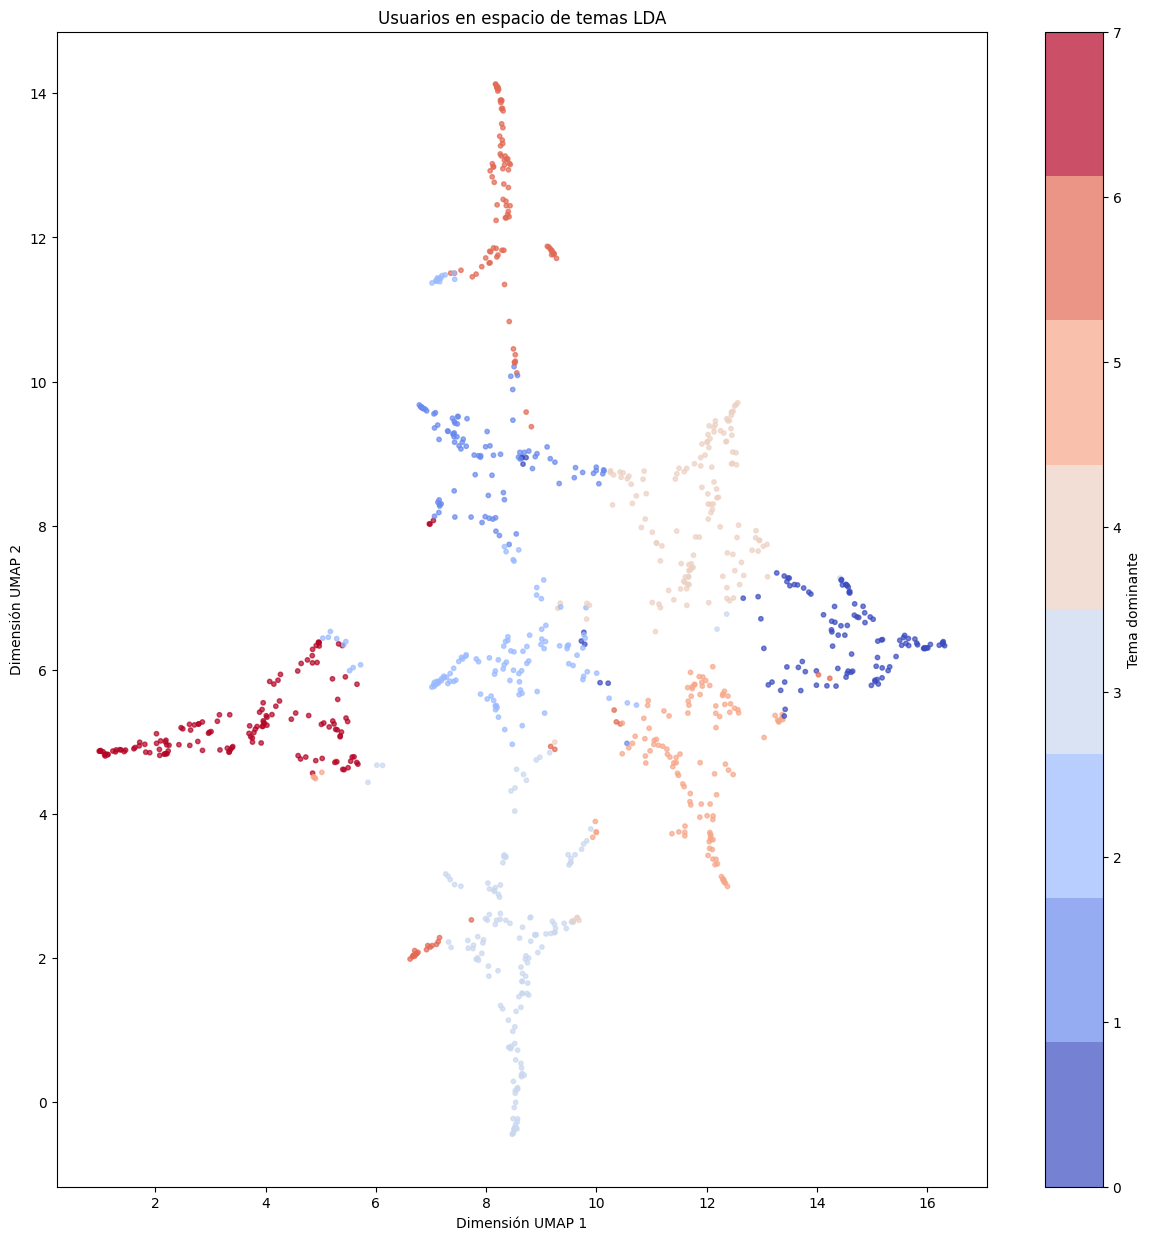

In [13]:
# Obtenemos la matriz usuario - tema
user_topic = lda.transform(user_artist_matrix)

# Calculamos para cada usuario el tema más relevante
dominant_topic = np.argmax(user_topic, axis=1)

# Reducimos a 2D con UMAP
reducer2 = umap.UMAP(random_state=100)
user_topic_2d = reducer2.fit_transform(user_topic)

plt.figure(figsize=(15, 15))
n_topics = user_topic.shape[1]
cmap = plt.get_cmap('coolwarm', n_topics)

scatter = plt.scatter(
    user_topic_2d[:, 0], user_topic_2d[:, 1],
    c=dominant_topic,
    cmap=cmap,
    s=10,
    alpha=0.7
)

plt.title('Usuarios en espacio de temas LDA')
plt.xlabel('Dimensión UMAP 1')
plt.ylabel('Dimensión UMAP 2')
plt.colorbar(label='Tema dominante')
plt.show()


## 3.3 Visualización de artistas y canciones

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Visualiza con matplotlib la proyección de artistas y de canciones al espacio latente de la dimensión seleccionada anteriormente. Muestra aleatoriamente las etiquetas (nombre del artista o título de la canción) de 100 puntos junto a éstos. No muestres todas las etiquetas porque taparían el contenido del gráfico.
</div>

In [14]:
# Proyectamos artistas al espacio de temas
artist_topic = lda.components_.T

# Ajustamos LDA sobre user_song_matrix
lda_song = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=10,
    random_state=100
)
lda_song.fit(user_song_matrix)
song_topic = lda_song.components_.T

# Reducimos a 2D
reducer = umap.UMAP(random_state=100)
artist_emb_2d = reducer.fit_transform(artist_topic)
song_emb_2d = reducer.fit_transform(song_topic)

c:\Users\Pablo\Desktop\Master UOC\Aprendizaje Automático\PEC2\pec2_venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


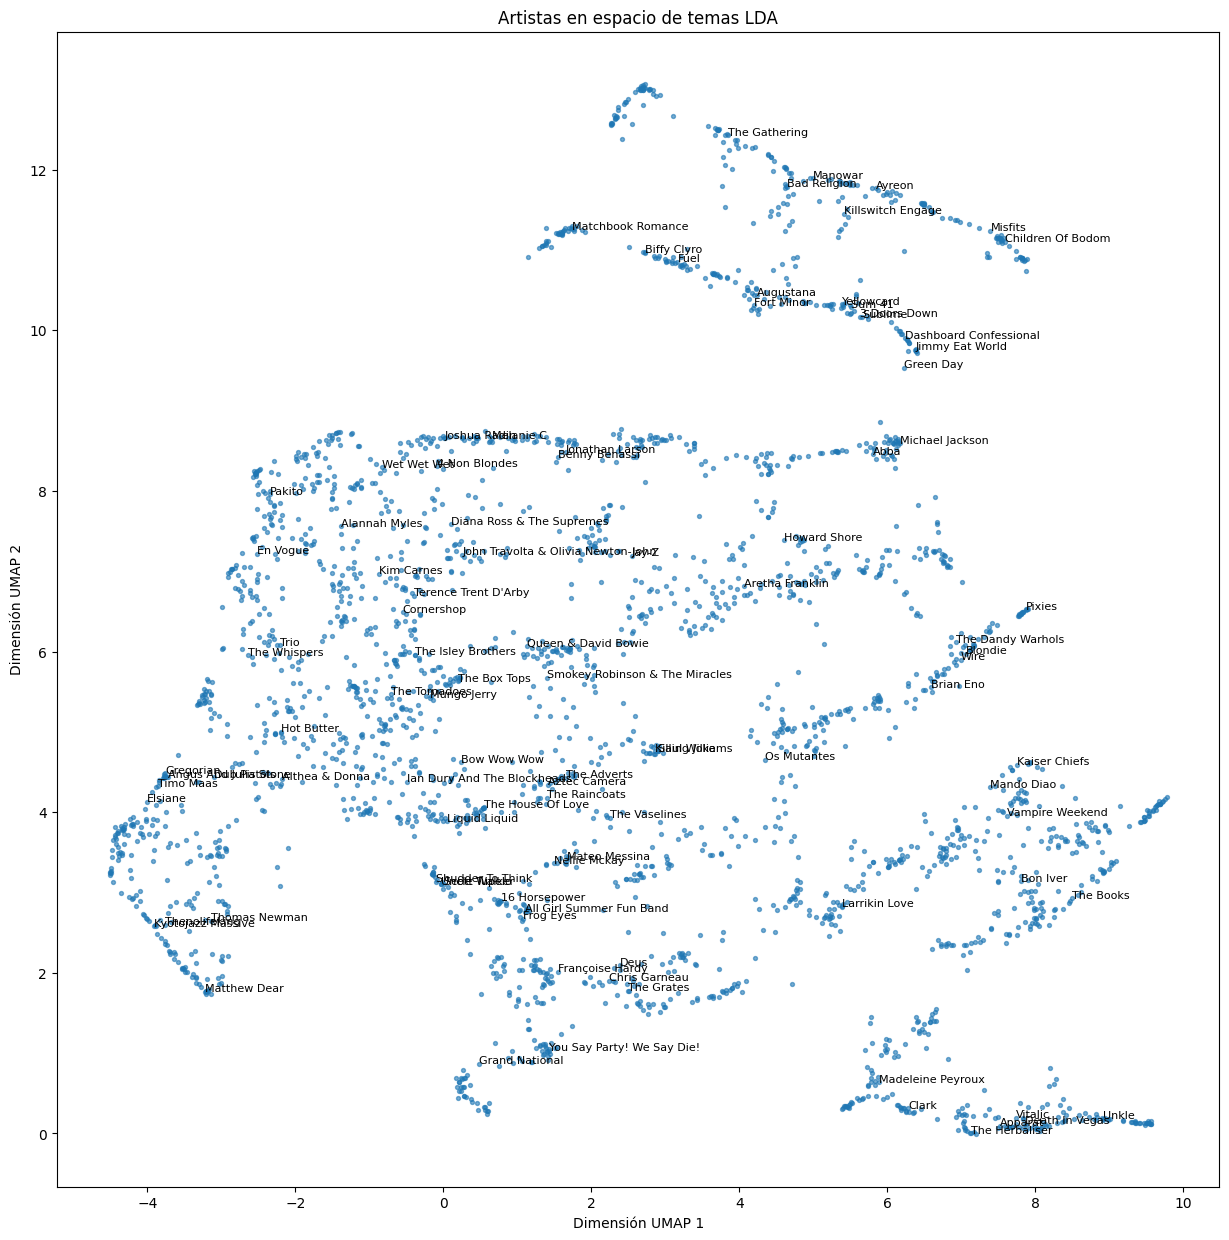

In [15]:
# Plot artistas
plt.figure(figsize=(15, 15))
plt.scatter(artist_emb_2d[:, 0], artist_emb_2d[:, 1], s=8, alpha=0.6)
# Etiquetar 100 artistas aleatoriamente
rng = np.random.RandomState(100)
idxs = rng.choice(len(artist_emb_2d), size=100, replace=False)
for idx in idxs:
    plt.text(artist_emb_2d[idx, 0], artist_emb_2d[idx, 1], unique_artists[idx], fontsize=8)
plt.title('Artistas en espacio de temas LDA')
plt.xlabel('Dimensión UMAP 1')
plt.ylabel('Dimensión UMAP 2')
plt.show()

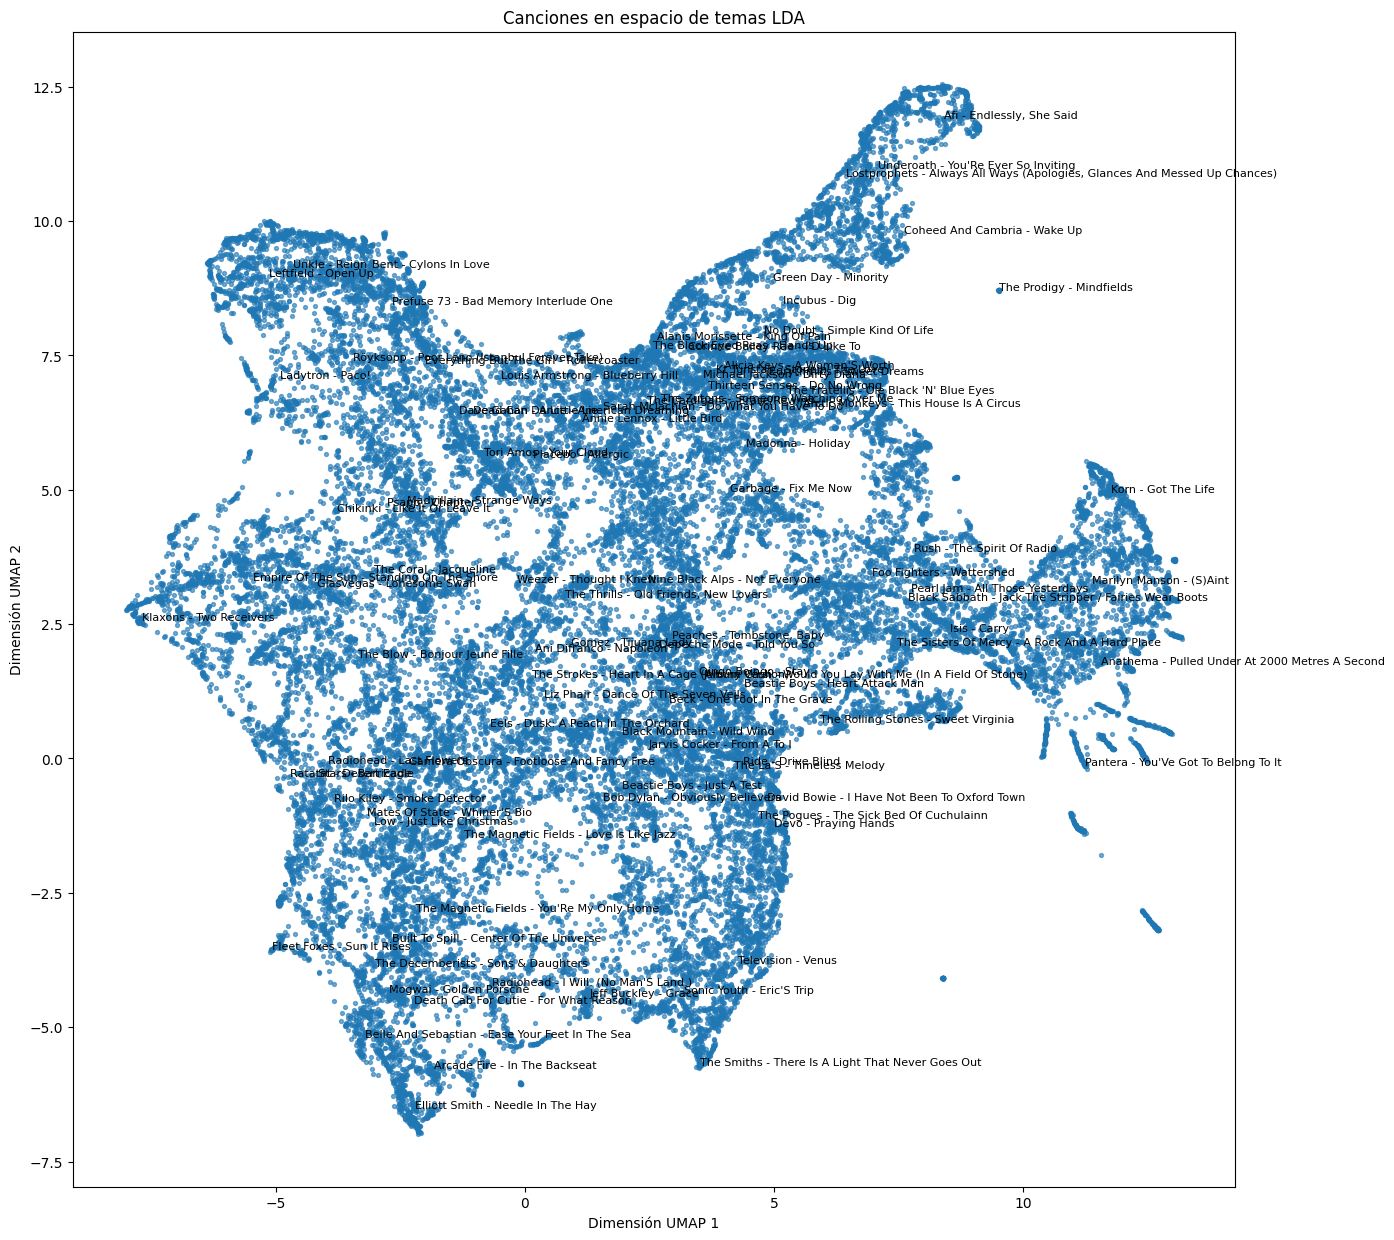

In [16]:
# Plot canciones
plt.figure(figsize=(15, 15))
plt.scatter(song_emb_2d[:, 0], song_emb_2d[:, 1], s=8, alpha=0.6)
# Etiquetar 100 canciones aleatoriamente
idxs = rng.choice(len(song_emb_2d), size=100, replace=False)
for idx in idxs:
    plt.text(song_emb_2d[idx, 0], song_emb_2d[idx, 1], unique_songs[idx], fontsize=8)
plt.title('Canciones en espacio de temas LDA')
plt.xlabel('Dimensión UMAP 1')
plt.ylabel('Dimensión UMAP 2')
plt.show()


## 3.4 Análisis de resultados

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué observas en las nuevas representaciones de artistas y canciones respecto a las anteriores? ¿A qué crees que se deben estas diferencias?
</div>

En las representaciones anteriores, dos artistas aparecían próximos si comparten muchos oyentes en común, pero sin que esos clusteres necesariamente correspondan a géneros o temas musicales bien definidos. El resultado era un mapa difuso, con zonas de mayor densidad (populares, hits…) y zonas más escasas (nicho, artistas poco escuchados), pero sin fronteras temáticas nítidas.

Al proyectar usando LD conseguimos clusters más temáticos, los artistas quedan agrupados en clusters mucho más homogéneos
e.g. tenemos un clúster donde predominan artistas de pop, otro de rock, otro de jazz, etc.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Si tuvieses que recomendar artistas o canciones nuevas a un usuario en base a lo aprendido con LDA ¿cómo lo harías?
</div>

Para cada persona, LDA nos dice qué mezcla de diferentes estilos le gusta: e.g. 50% Pop, 30% Rock, 20% Jazz.

De forma análoga, LDA nos da para cada artista o canción su propia mezcla: e.g. Michael Jackson es 80% Pop, 20% Flamenco. (ejemplo ramdom inventado, evidentemente Michael Jackson no canta flamenco)

Para recomendar, simplemente medimos qué tan parecida son los estilos del usuario con los de cada artista (o canción). Cuanto más coincidan los porcentajes (Pop con Pop, Rock con Rock, …) más alto será la puntuación de recomendación.

Ordenamos todos los artistas según esa puntuación, quitamos los que la persona ya ha escuchado y mostramos los primeros.

## 4. Proyectar para recomendar: factorización de matrices (3 puntos)

Hasta ahora hemos usado coocurrencia y LDA para representar a los usuarios y detectar patrones de escucha. Pero... ¿y si existiera una proyección pensada específicamente para **recomendar**?

Aquí entra en juego una nueva familia de métodos: **factorización de matrices**.

Estos métodos se han convertido en una de las herramientas más utilizadas en sistemas de recomendación (sí, como el de Netflix o Spotify), porque permiten:

- **Predecir qué canciones o artistas gustarán a cada usuario**.
- **Reducir la dimensionalidad** y representar tanto a usuarios como a ítems (artistas o canciones) en un **mismo espacio vectorial**.
- **Aprender afinidades**: si un usuario y un artista tienen vectores similares, es probable que ese usuario disfrute de ese artista.

Algunos de los modelos de recomendación más conocidos:

- **SVD (Singular Value Decomposition)**: descompone la matriz en componentes ortogonales, útil cuando tenemos una matriz densa.
- **NNMF (Non-negative Matrix Factorization)**: como SVD, pero impone que los factores sean positivos, lo que facilita la interpretación (no hay gustos negativos).
- **ALS (Alternating Least Squares)**: muy usado en sistemas de recomendación, especialmente con matrices dispersas. Alterna entre actualizar usuarios e ítems hasta converger.
- **BPR (Bayesian Personalized Ranking)**: orientado a recomendaciones por ranking, no por puntuación.
- **LightFM o DeepFM**: integran contenido e interacción en modelos híbridos (más complejos, no los veremos aquí, pero vale la pena conocerlos).

Aunque también estamos reduciendo dimensionalidad, la **finalidad principal no es visualizar ni interpretar temas**, sino **reconstruir las preferencias faltantes en la matriz original**.

Dicho de otra forma: en LDA, proyectábamos usuarios sobre un espacio de temas **que explicaban su comportamiento**. En la factorización, proyectamos usuarios e ítems en un espacio donde **su cercanía indica afinidad**, y podemos **predecir lo que falta**.

![ALS](https://media.springernature.com/lw685/springer-static/image/chp%3A10.1007%2F978-3-030-03405-4_18/MediaObjects/475251_1_En_18_Fig1_HTML.png)

Es otra forma de "ver el dato", y nos da nuevas posibilidades de análisis y recomendación.

## 4.1 Entrenamiento de ALS

Dado que el dato del dataset es muy disperso, [ALS](http://yifanhu.net/PUB/cf.pdf) es una buena elección. Utilizaremos la implementación de la [librería implicit](https://github.com/benfred/implicit). Para tener una intuición de su funcionamiento recomendamos [este video](https://youtu.be/DJR_6fkG66s).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Entrena un modelo ALS con la matriz de coocurrencia precalculada user_artist_matrix y almacena en las variables user_embeddings y artist_embeddings los factores latentes aprendidos por el modelo. Puedes usar el mismo número de factores latentes que has seleccionado en el ejercicio anterior para LDA.
</div>

In [19]:
# usamos el mismo número de factores latentes que has seleccionado en el ejercicio anterior para LDA
n_factors = n_topics 

# Creamos el modelo ALS
model = AlternatingLeastSquares(
    factors=n_factors,
    iterations=10, 
    random_state=100
)

# Entrenamos el modelo
model.fit(user_artist_matrix)

# Extraemos los embeddings:
user_embeddings   = model.user_factors
artist_embeddings = model.item_factors

print("user_embeddings =", user_embeddings.shape)
print("artist_embeddings =", artist_embeddings.shape)


c:\Users\Pablo\Desktop\Master UOC\Aprendizaje Automático\PEC2\pec2_venv\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

user_embeddings = (991, 8)
artist_embeddings = (2821, 8)


In [20]:
assert len(user_embeddings) == 991, '# of users does not match!'
assert len(artist_embeddings) == 2821, '# of artists does not match!'

## 4.2 Visualización de usuarios

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Si el embedding de usuario tiene más de dos dimensiones, reduce su dimensionalidad con UMAP. Visualiza con matpltolib los usuarios en el nuevo espacio latente reducido.
</div>

c:\Users\Pablo\Desktop\Master UOC\Aprendizaje Automático\PEC2\pec2_venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


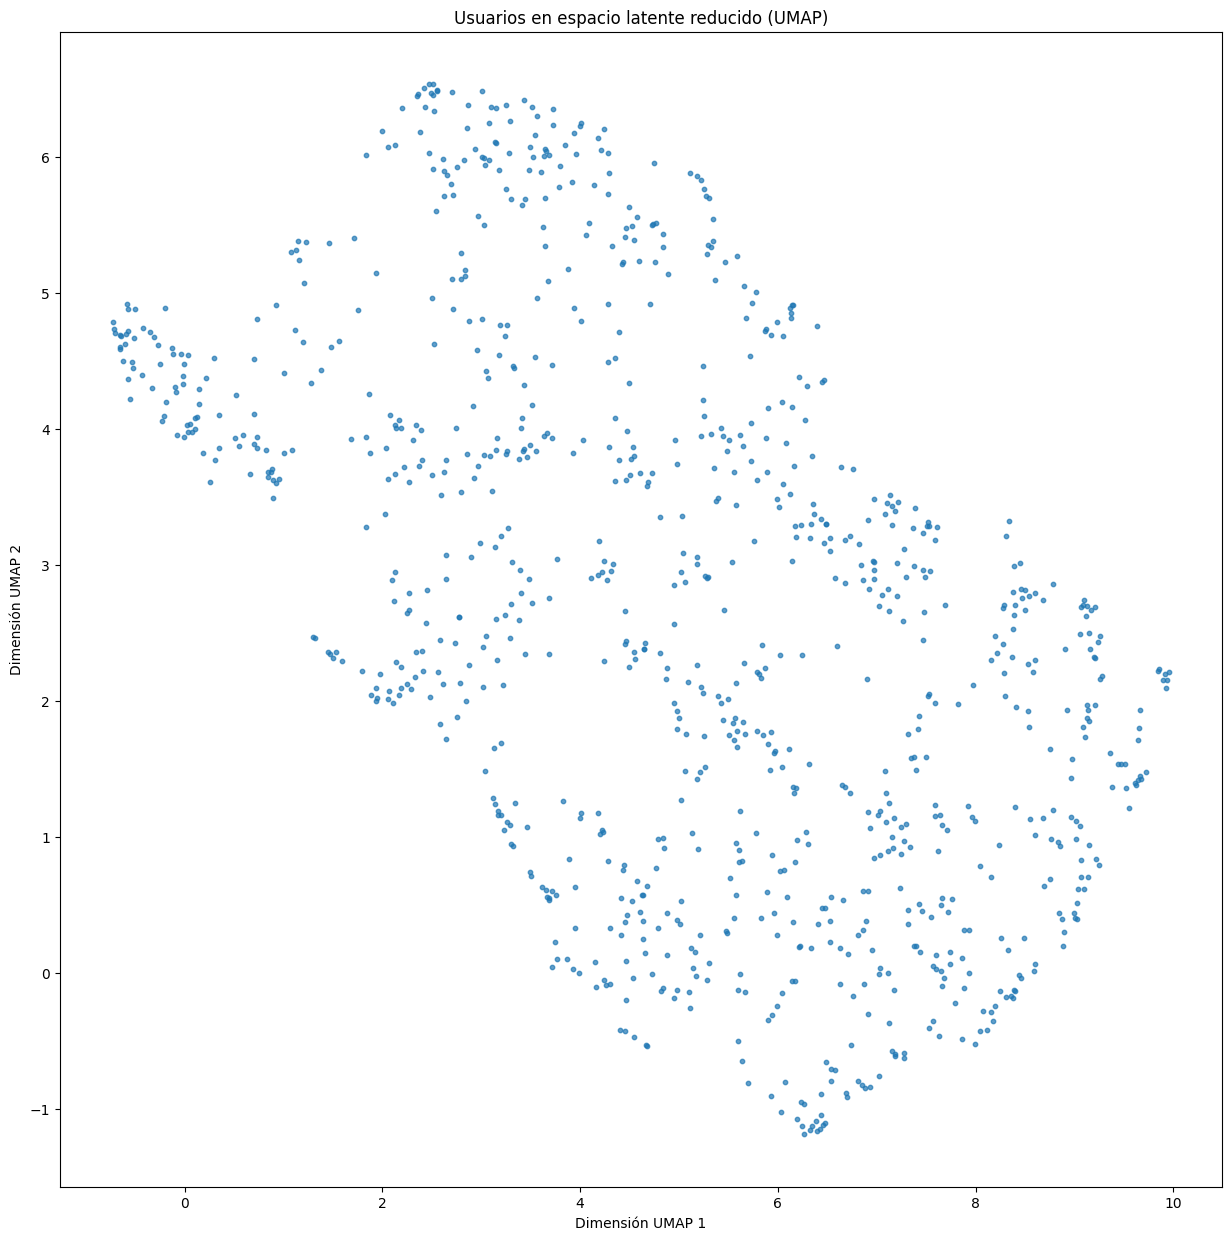

In [21]:
reducer = umap.UMAP(random_state=100)
user_emb_2d = reducer.fit_transform(user_embeddings)

plt.figure(figsize=(15, 15))
plt.scatter(user_emb_2d[:, 0], user_emb_2d[:, 1], s=10, alpha=0.7)
plt.title('Usuarios en espacio latente reducido (UMAP)')
plt.xlabel('Dimensión UMAP 1')
plt.ylabel('Dimensión UMAP 2')
plt.show()

## 4.3 Visualización de artistas

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Si el embedding de artistas tiene más de dos dimensiones, reduce su dimensionalidad con UMAP. Visualiza con matpltolib los usuarios en el nuevo espacio latente reducido. Muestra aleatoriamente las etiquetas (nombre del artista) de 100 puntos junto a éstos. No muestres todas las etiquetas porque taparían el contenido del gráfico.
</div>

c:\Users\Pablo\Desktop\Master UOC\Aprendizaje Automático\PEC2\pec2_venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


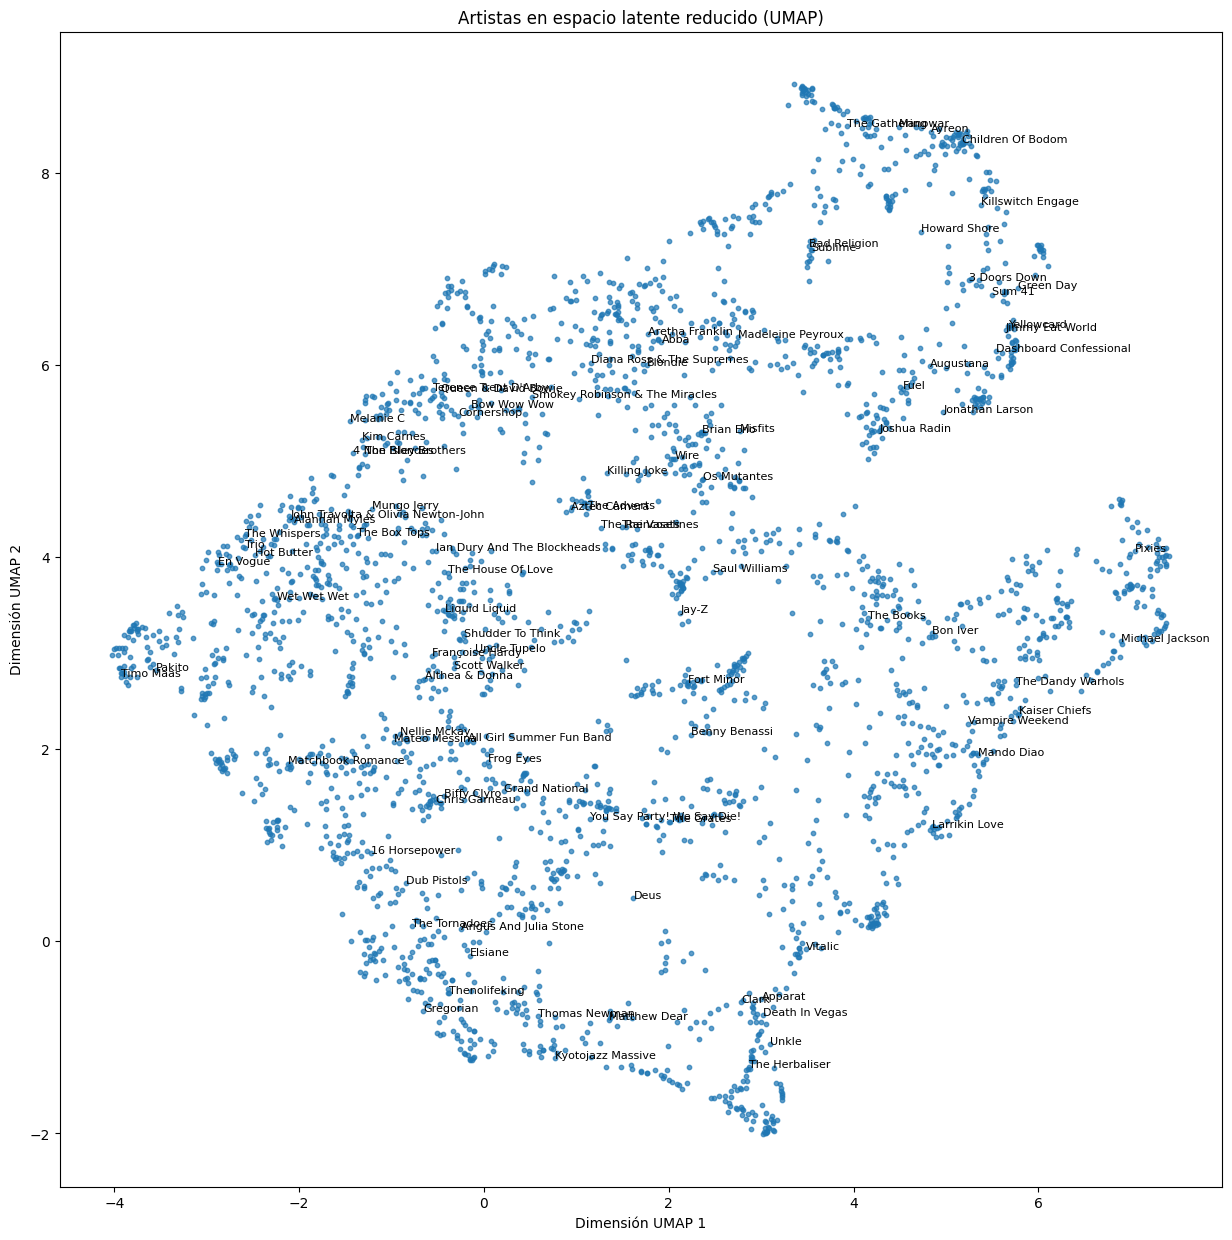

In [22]:
reducer = umap.UMAP(random_state=100)
artist_emb_2d = reducer.fit_transform(artist_embeddings)

plt.figure(figsize=(15, 15))
plt.scatter(artist_emb_2d[:, 0], artist_emb_2d[:, 1], s=10, alpha=0.7)
plt.title('Artistas en espacio latente reducido (UMAP)')
plt.xlabel('Dimensión UMAP 1')
plt.ylabel('Dimensión UMAP 2')

# Creamos etiquetas para 100 artistas al azar
rng = np.random.RandomState(100)
n_art = artist_emb_2d.shape[0]
idxs = rng.choice(n_art, size=100, replace=False)
for i in idxs:
    x, y = artist_emb_2d[i]
    plt.text(x, y, unique_artists[i], fontsize=8)

plt.show()


## 4.4 Recomendación de artistas

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Ahora que tienes el modelo usario-artistas entrenado, utiliza el método recommend para mostrar el top 10 de recomendaciones para un usuario cualquiera. Muestra también los artistas que ha consumido ese usuario. ¿Tienen relación?
</div>

In [23]:
# Índice de usuario para el que queremos recomendaciones
u = 0  

# Obtenemos los artistas que el usuario ya ha escuchado
listened_idxs = user_artist_matrix[u].indices
print("Artistas consumidos por el usuario:")
for i in listened_idxs:
    print("  •", idx_to_artist[i])

# Ahora pedimos las top 10 recomendaciones al modelo ALS
ids, scores = model.recommend(
    userid=u,
    user_items=user_artist_matrix[u],
    N=10,
    filter_already_liked_items=True
)

print("\nTop 10 recomendaciones:")
for art_idx, score in zip(ids, scores):
    print(f"  • {idx_to_artist[art_idx]} (puntuación = {score:.3f})")


Artistas consumidos por el usuario:
  • Minus 8
  • 4Hero
  • Röyksopp
  • Bugge Wesseltoft
  • Fleet Foxes
  • Miss Kittin & The Hacker
  • The Cinematic Orchestra
  • Björk
  • Moby
  • Radiohead
  • Clark
  • The Verve
  • Uh Huh Her
  • Boards Of Canada
  • Prefuse 73
  • Yael Naim
  • Coldplay
  • Tiga
  • Enya
  • Herbert
  • Amy Winehouse
  • Amon Tobin
  • Fink
  • The Herbaliser
  • Daedelus
  • Plaid
  • Everything But The Girl
  • Flying Lotus
  • Jamie Lidell
  • Thomas Newman
  • Oasis
  • Burial
  • Sade
  • Jazzanova
  • Digitalism
  • Underworld
  • Sébastien Tellier
  • Herbie Hancock
  • The Chemical Brothers
  • Aphex Twin
  • Erykah Badu
  • Afterlife
  • Pendulum
  • Janet Jackson
  • Ludwig Van Beethoven
  • Rjd2
  • Jaga Jazzist
  • Blockhead
  • Mika
  • Nitin Sawhney
  • Madlib
  • Gabin
  • Fila Brazillia
  • Red Hot Chili Peppers
  • Squarepusher
  • Billy Joel
  • Koop
  • Cornelius
  • Thom Yorke
  • Orbital
  • Afx
  • U2
  • The Ballistic Brothers
  • Lev

## 4.5 Entrenamiento y recomendación de canciones

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Calcula el embedding de las canciones. Si tiene más de dos dimensiones, reduce su dimensionalidad con UMAP. Visualiza con matpltolib los usuarios en el nuevo espacio latente reducido. Muestra aleatoriamente las etiquetas (nombre del artista) de 100 puntos junto a éstos. No muestres todas las etiquetas porque taparían el contenido del gráfico.
</div>

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\Pablo\Desktop\Master UOC\Aprendizaje Automático\PEC2\pec2_venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


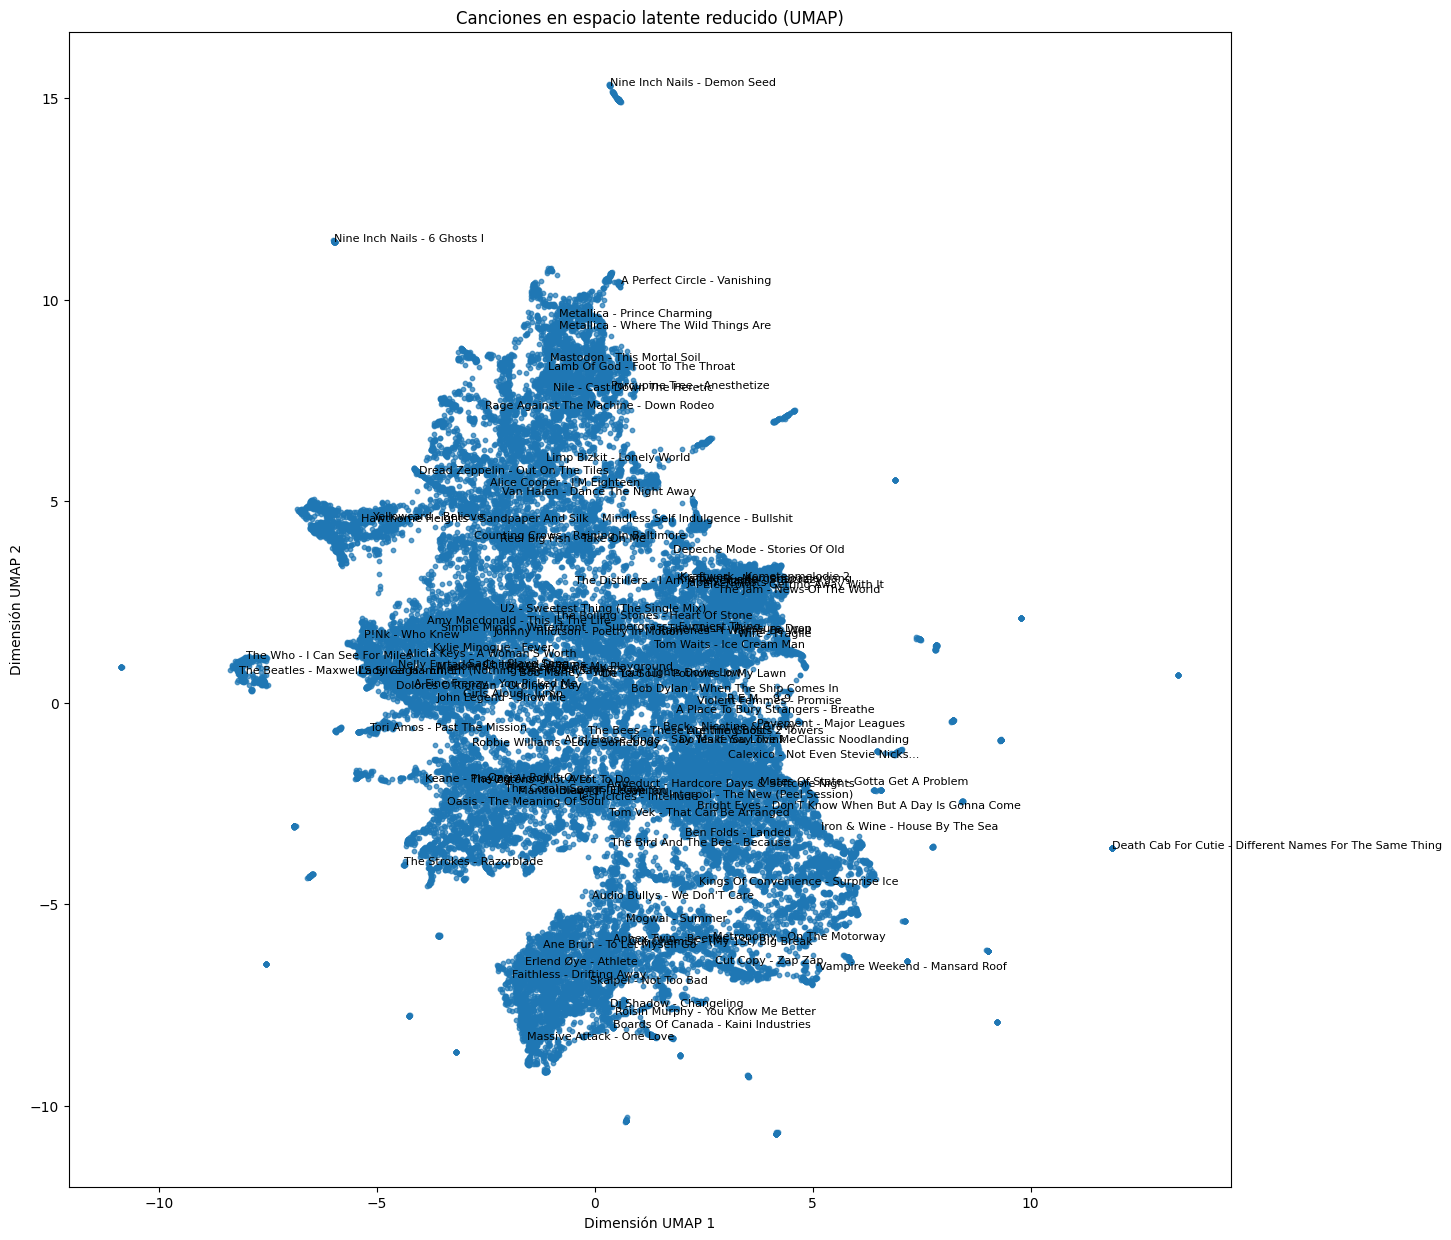

In [24]:
# Creamos el modelo ALS para songs
model_song = AlternatingLeastSquares(factors=n_factors, iterations=10, random_state=100)
# Entrenamos el modelo
model_song.fit(user_song_matrix)
# Extraemos los embeddings
song_embeddings = model_song.item_factors
# Reducimos a espacio 2D
reducer = umap.UMAP(random_state=100)
song_emb_2d = reducer.fit_transform(song_embeddings)

plt.figure(figsize=(15, 15))
plt.scatter(song_emb_2d[:, 0], song_emb_2d[:, 1], s=10, alpha=0.7)
plt.title('Canciones en espacio latente reducido (UMAP)')
plt.xlabel('Dimensión UMAP 1')
plt.ylabel('Dimensión UMAP 2')

# Creamos etiquetas para 100 canciones al azar
rng = np.random.RandomState(100)
n_art = song_emb_2d.shape[0]
idxs = rng.choice(n_art, size=100, replace=False)
for i in idxs:
    x, y = song_emb_2d[i]
    plt.text(x, y, unique_songs[i], fontsize=8)

plt.show()

In [25]:
assert len(song_embeddings) == 32790, '# of songs does not match!'

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué enfoque de clustering usarias? ¿Y qué algoritmo en concreto? ¿Por qué?
</div>


Lo unico que se es que no usaria un k means constrained ya que no sabemos el tamaño mínimos/máximos de cada clúster. Ademas para el k-means debemos seleccionar k y en nuestro embedding musical, no sabemos a priori si hay 8, 12 o más géneros.

Con k‑means no hay puntos de ruido, cualquier artista por muy raro o de nicho que sea debe entrar en uno de los k clusters. En música hay siempre artistas outliers que no caben bien en ningún género mayoritario. Sin embargo DBSCAN marca esos outliers como ruido asi que sería una alternativa curiosa a probar.

Me encantaria probar DBSCAN pero no me da tiempo de realizar el clustering :(

## [OPCIONAL] 5. Contexto lo es todo: proyectando artistas y canciones con item2vec

Hasta ahora hemos representado a los artistas y canciones como puntos en espacios temáticos (LDA) o latentes (factorización), centrándonos en cómo se relacionan con los usuarios. Pero... ¿qué pasaría si en lugar de mirar **quién los escucha**, observamos **cómo se consumen juntos en la práctica**?

Aquí entra en juego una técnica inspirada en el procesamiento del lenguaje natural: [**item2vec**](https://arxiv.org/pdf/1603.04259).

Es una adaptación del famoso modelo [**word2vec**](https://arxiv.org/pdf/1301.3781), pero en lugar de predecir palabras en frases, **aprende a representar ítems (en este caso, canciones o artistas) a partir del contexto en que aparecen**. Todo de una manera no supervisada.

La diferencia principal entre word2vec e item2vec estriba en que **word2vec asume que el orden de las palabras importa en la frase, mientras que item2vec no**. Eso permite aplicar item2vec a conjuntos de datos como carritos de la compra donde desconoces el orden en el que el cliente introdujo los productos al carrito.

La intuición es simple: si dos canciones suelen escucharse dentro de una misma sesión, probablemente comparten algo en común, **aunque no sean exactamente del mismo género**.

Esto es muy diferente a los modelos anteriores:
- **Coocurrencia** basado en la estructura de escucha.
- **LDA** enfoque probabilístico apoyándose en temas latentes.
- **Factorización** mira preferencias individuales.
- **item2vec** **atiende al "contexto de escucha"**, como si fueran palabras dentro de frases.

Un aspecto clave de item2vec es que dos artistas **no tienen por qué escucharse juntos** para acabar proyectados *cerca*.  
Si **ambos aparecen en contextos parecidos**, se colocan en la misma zona del espacio de embeddings.

Por eso, item2vec puede descubrir **afinidades ocultas** entre artistas que nunca han coincidido directamente, pero que comparten **un mismo tipo de oyente o ambiente de escucha** (A y B pueden no haber coincidido en ninguna sesión, pero A tiene como contexto a C, D y E, al igual que B).

Uno de los aspectos más interesanes de este enfoque es la semántica que es capaz de capturar y forma parte de **los cimientos de los LLMs**: la **proyección algebraica permite realizar operaciones en el nuevo espacio simplemente sumando o restando vectores**, como en la siguiente imagen.

![Word2Vec](https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/06062705/Word-Vectors.png)

Para indagar más en el modelo word2vec recomendamos [este artículo](https://jalammar.github.io/illustrated-word2vec/). También en [este video sobre word2vec](https://youtu.be/viZrOnJclY0). Y [este otro](https://www.youtube.com/watch?v=FJtFZwbvkI4) sobre word embeddings.

## 5.1 Representación matricial artista-artista

La implementación rigurosa nos llevaría a un conjunto de entrenamiento muy grande (dada la combinatoria) y a implementar técnicas adicionales como negative sampling. Para simplificarlo, el contexto de un artista vendrá dado por la coocurrencia con otros artistas. Por lo que comenzaremos calculando la matriz `artist_artist_matrix` a partir de la matriz que preparamos en la primera sección: `user_artist_matrix`. Dado que el contexto se comparará con la salida de una función `softmax` también vamos a normalizar la matriz por filas. De esta manera las épocas de entrenamiento serán más livianas, a la larga el resultado será bastante similar, pues se acaba aproximando la matriz de coocurrencia.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> A partir de la matriz user_artist_matrix calcula la matriz artist_artist_matrix donde cada celda indique el número de usuarios que han escuchado al artista de la fila y al de la columna. Normaliza las filas de la matriz para entrenar el modelo.
</div>

Para simplificar la tarea, aquí está el código de PyTorch referente al Dataset que carga la matriz calculada en el paso anterior:

In [ ]:
class ArtistArtistDataset(Dataset):

    def __init__(self, matrix):
        self.matrix = torch.tensor(matrix, dtype=torch.float32)

    def __len__(self):
        return self.matrix.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(idx, dtype=torch.long), self.matrix[idx]

artist_dataset = ArtistArtistDataset(artist_artist_matrix_norm)
artist_dataloader = DataLoader(artist_dataset, batch_size=512, shuffle=True)

## 5.2 Diseño de la red y entrenamiento

Ahora definiremos la red neuronal diseñada para que, dado un artista, aprenda a predecir su “contexto”: los artistas que suelen escucharse junto a él. Imitando al modelo item2vec con un enfoque tipo Skip-Gram.

La implementaremos a través de la clase `ArtistModel`que consta de los siguientes métodos:

`__init__`

Contendrá una capa de `Embedding` que proyecte a la dimensión que deseemos (en este caso 2 por fines didácticos, ya que aprenderá una representación en baja dimensionalidad todo en uno), que de verdad es lo que nos interesa, pues nos permite asociar un índice de artista a una representación vectorial (embedding). Y por último, una capa `Lineal` que proyecte de 2 dimensiones al número de artistas (el contexto).

`forward`

Aquí conectamos las capas que hemos definido en `__init__` de tal manera que recibimos un índice, este se lo pasamos a la capa de `Embedding` para recuperar su representación vectorial (2d), de aquí a la capa `Lineal` que proyectará al contexto (de dimensión número de artistas). Por último, aplicar y devolver el resultado de la función `softmax` a la salida de la capa `Lineal` que en el bucle principal (fuera del método) la compararemos con la fila correspondiente de la matriz `artist_artist_matrix`.

```
class ArtistModel(nn.Module):

    def __init__(self, n_artists, embedding_dim=2):
        super().__init__()
        ...

    def forward(self, artist_indices):
        ...
```

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Completa los métodos de la clase ArtistModel con lo descrito anteriormente.
</div>

El siguiente código se corresponde al bucle de entrenamiento donde relacionamos el dataset que se carga y se conecta con el modelo para alimentarlo.

Destacar:

 - Se ejecutarán 500 epochs, es decir, el modelo verá el dataset completo 500 veces.
 - `for artist_idx, context_dist in artist_dataloader:` aquí se ejecutarán minibatches (el dataset por partes) hasta recorrer el dataset completo (una epoch).
 - `log_probs = model(artist_idx)` se hace una pasada por el modelo entrando un índice y obteniendo su log_probs (la salida).
 - `loss = criterion(log_probs, context_dist)` aquí se comparan las predicciones con el contexto calculado en la matriz `artist_artist_matrix`. Previamente se ha definido `criterion` como `KL divergence` que mide cuanto se alejan las dos distribuciones.
 - `loss.backward()` propaga para atrás las diferencias, haciendo efectivo el entrenamiento de la red.

Durante el proceso de entrenamiento verás como la loss (el error) decrece hasta llegar a estabilizarse.

In [ ]:
model = ArtistModel(n_artists=len(artist_artist_matrix), embedding_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
criterion = nn.KLDivLoss(reduction='batchmean')

n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for artist_idx, context_dist in artist_dataloader:
        log_probs = model(artist_idx)
        loss = criterion(log_probs, context_dist)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(artist_dataloader)
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.4f}")

## 5.3 Visualización de artistas

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Recupera los embeddings aprendidos por el modelo y visualiza los artistas proyectados en el espacio 2d. Muestra aleatoriamente las etiquetas (nombre del artista) de 100 puntos junto a éstos. No muestres todas las etiquetas porque taparían el contenido del gráfico.
</div>

La nueva representación es un tanto distinta de las demás porque a diferencia de las anteriores, es recomendable usar similitud de coseno en lugar la distancia euclídea porque dos vectores pueden apuntar en la misma dirección (muy similares), pero estar a diferente escala (longitud).

Por ejemplo: [1, 1] y [100, 100] están muy lejos euclídeamente, pero apuntan exactamente en la misma dirección → son el mismo tipo de artista, solo con más magnitud (más popular, más escuchado…).

La euclídea penaliza la escala, no solo la dirección. Pero en los embeddings, lo importante es la dirección del vector, que representa el estilo, el contexto o la posición semántica.

Mientras que la similitud de coseno oscila entre -1 (opuestos) y 1 (idénticos). Dos vectores con similitud coseno cercana a 1 están en la misma dirección, por tanto, son similares. Y dos vectores con similitud 0 son ortogonales, sin relación. Se ha observado que la similitud de coseno encaja mejor la representación de la red con la interpretación de los embeddings.



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Cómo recomendarías artistas a un usuario con algo de histórico de escucha?
</div>